This is an implementation of the base MAMBA model as introduced in https://srush.github.io/annotated-mamba/hard.html 

If you want an easier explanation of it, this is recommended: https://jackcook.com/2024/02/23/mamba.html

I read a bunch of papers and blogs related to SSMs and Mamba and found that my understanding of it was still lacking. As they say,
when you really want to understand a model you implement it from scratch. So I did. (thankfully the Mamba: the hard way article above
had already done the work, so I just rewrote that code line by line to get a more thorough understanding of it. They REALLY mean the HARD way, btw).

In [4]:
import triton
import triton.language as tl
import torch
import math
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : False})
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def check(*inputs, prec=1e-4):
    for i, (a, b) in enumerate(zip(inputs[::2], inputs[1::2])):
        if isinstance(b, list):
            b = torch.tensor(b)
        c = torch.allclose(a.cpu(), b.cpu(), prec)
        c1 = torch.isclose(a.cpu(), b.cpu(), prec)
        assert c, f"{i}\n{a}\n{b}\n{c1}"
    print("✔️")

## Getting used to Triton

In [5]:
@triton.jit
def triton_hello_world(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
    # Use arange to build the shape for loading
    Ks = tl.arange(0, K) # K
    Ls = tl.arange(0, L)[:, None] # L x 1

    # Load from memory
    x = tl.load(X + Ks) # K
    y = tl.load(Y + Ls*K + Ks) # L x K
    z = x + y # L x K

    # Store
    tl.store(Z + Ls*K + Ks, z) # L x K

x, y = arange(4),ones(8, 4)
z = zeros(8, 4)
triton_hello_world[(1,)](x, y, z, 4, 8)
z

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]], device='cuda:0')

In [6]:
@triton.jit
def triton_hello_world_block(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
    # Run each program in parallel
    pid = tl.program_id(0)
    lid = pid * L

    # Use arange to build the shape for loading
    Ks = tl.arange(0, K) # K
    Ls = tl.arange(0, L)[:, None] # L x 1

    # Load from memory
    x = tl.load(X + Ks) # K

    # Load based on program id.
    y = tl.load(Y + (Ls + lid) *K + Ks) # L x K
    z = x + y # L x K

    # Store
    tl.store(Z + (Ls + lid) * K + Ks, z) # L x K

L = 2**10
x, y = arange(4),ones(L, 4)
z = zeros(L, 4)
num_blocks = 8
triton_hello_world_block[(L // num_blocks,)](x, y, z, 4, num_blocks)
z.shape, z


(torch.Size([1024, 4]),
 tensor([[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         ...,
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]], device='cuda:0'))

## Cumulative Sum

<BarContainer object of 128 artists>

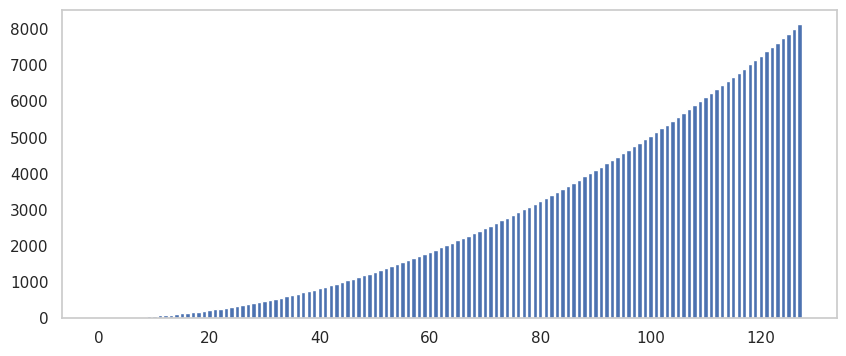

In [7]:
# Constants used throughout
K = 16
BLOCKS = 8
SEQLEN = K * BLOCKS

x = arange(SEQLEN)
y = zeros(SEQLEN)

def cumsum(x):
    y = []
    h = 0
    for k in range(len(x)):
        h = h + x[k]
        y.append(h)
    return h, y
h_, y_ = cumsum(x.cpu())
plt.bar(range(SEQLEN), y_)

In [8]:
@triton.jit
def plus_fn(a, b):
    # This is a helper function where a and b are tensors.
    return a + b

@triton.jit
def cumsum1_tt(X, Y, H, K: tl.constexpr):
    # This is the base triton function. Capital letters are pointers to memory.

    # Create a tensor from 0 to K - 1
    Ks = tl.arange(0, K)

    # Load in a sequence of K x's (blue)
    x = tl.load(X + Ks)

    # Compute h (green) and y (yellow) on axis 0.
    hs = tl.associative_scan(x, 0, plus_fn)
    y = hs

    # Write out K y's
    tl.store(Y + Ks, y)

    # Write out only the last h to memory.
    tl.store(H + Ks * 0, hs, mask=Ks == (K-1))

# Test to confirm it runs on the GPU.
h = zeros(1)
cumsum1_tt[(1,)](x, y, h, K=K)

h_, y_ = cumsum(x[:K].tolist())
check(h[0], [h_], y[:K], y_)

✔️


In [9]:
@triton.jit
def cumsum_tt(X, H_0, Y, H, K: tl.constexpr):
    # Which block an I?
    pid = tl.program_id(0)

    # How far into the sequence am I?
    kid = K * pid
    Ks = tl.arange(0, K)

    # Load in K x's per block and 1 starting h
    x = tl.load(X + Ks + kid)

    # Load the first value as H_0 and the rest 0
    h_0 = tl.load(H_0 + Ks * 0 + pid, Ks == 0, 0)

    # Allow for a starting value.
    x = plus_fn(h_0, x)

    # Compute scan
    hs = tl.associative_scan(x, 0, plus_fn)
    y = hs

    # Write out K y's per block and 1 h
    tl.store(Y + Ks + kid, y)

    # Write out only the last value to H
    tl.store(H + Ks * 0 + pid, hs, mask=Ks == (K-1))

h = zeros(BLOCKS)
cumsum_tt[(BLOCKS,)](x, h, y, h, K=K)
h_, y_ = cumsum(x[K:2 * K].tolist())
assert h_ == h[1]

In [10]:
def cumsum_block(x, y, K):
    seqlen = y.shape[0]
    BLOCKS = seqlen // K
    h = zeros(2, BLOCKS)
    cumsum_tt[(BLOCKS,)](x, h[0], y, h[0], K=K)
    h[1, 1:] = h[0].cumsum(0)[:-1]
    cumsum_tt[(BLOCKS,)](x, h[1], y, h[1], K=K)

cumsum_block(x, y, K)
h_, y_ = cumsum(x.tolist())
check(y, y_)

✔️


In [11]:
y_out = zeros(2**25)
x_gpu = ones(2**25)
x_ = x_gpu.cpu()


In [12]:
%%timeit
x_.cumsum(0)

84 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
cumsum_block(x_gpu, y_out, K = 2**10)

10.7 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Exponential Moving Average

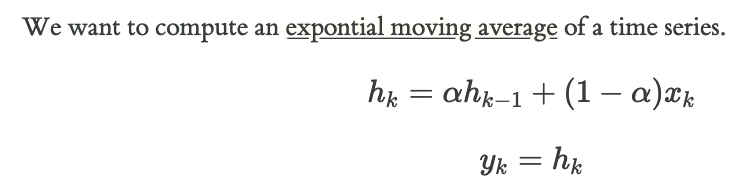

<BarContainer object of 128 artists>

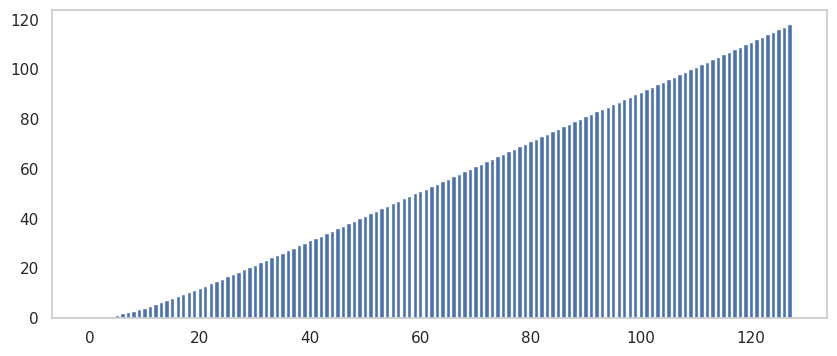

In [14]:
alpha = 0.9
def ema(x, alpha):
    y = []
    h = 0
    for k in range(len(x)):
        h = alpha * h + (1-alpha) * x[k]
        y.append(1 * h)
    return h, y

h_, y_ = ema(range(SEQLEN), alpha)
plt.bar(range(SEQLEN), y_)

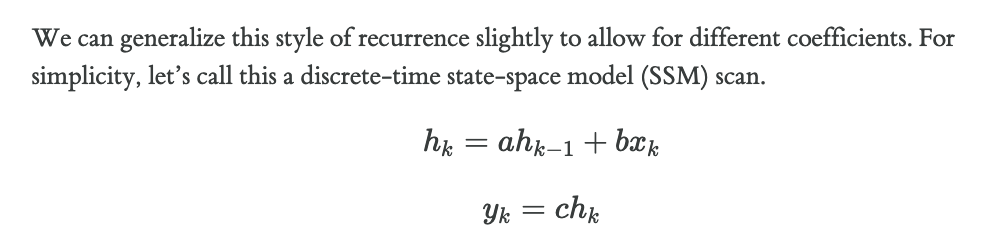

In [15]:
def ssm_scan(x, a, b, c):
    y = []
    h = 0
    for k in range(len(x)):
        h = h * a + b * x[k]
        y.append(c * h)
    return h, y

h_, y_ = ssm_scan(range(SEQLEN), alpha, (1-alpha), 1)

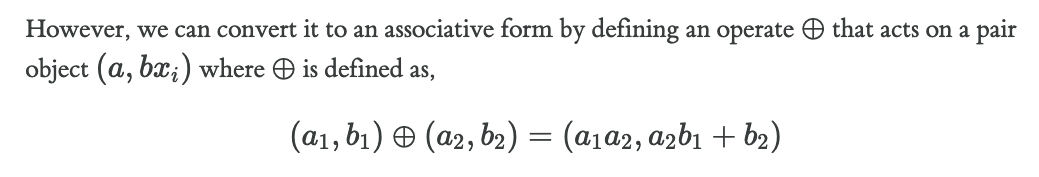

<BarContainer object of 128 artists>

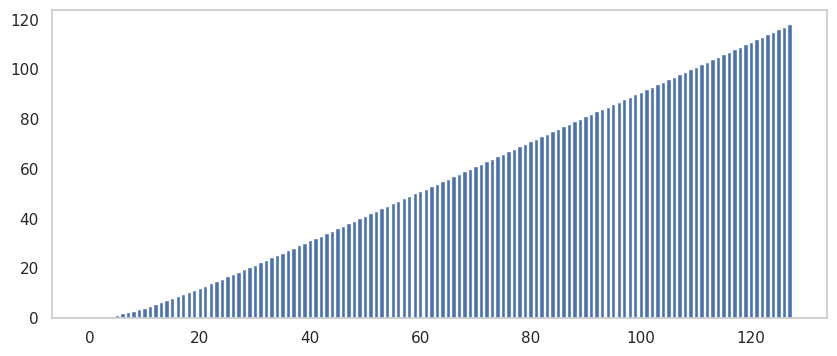

In [16]:
def op(a, b):
    return (a[0] * b[0], b[0] * a[1] + b[1])

def ssm_associative(x, a, b, c):
    y = []
    h = (alpha, 0)
    for k in range(len(x)):
        h_new = (a, b * x[k])
        h = op(h, h_new)
        y.append(c * h[1])
    return h, torch.stack(y)

assert ema(x, alpha)[0] == ssm_associative(x, alpha, 1-alpha, 1)[0][1]
h_, y_ = ssm_associative(x, alpha, 1-alpha, 1)
plt.bar(range(SEQLEN), y_.cpu())

In [17]:
@triton.jit
def first_order_op(fl, xl, fr, xr):
    f = fr * fl
    x = fr * xl + xr
    return f, x

In [18]:
@triton.jit
def ssm_load(Ks, A, B, C):
    "Helper for loading"
    a = tl.load(A + Ks)
    b = tl.load(B + Ks)
    c = tl.load(C + Ks)
    return a, b, c

@triton.jit
def simple_ssm_tt(X, A, B, C, Y, K: tl.constexpr):
    Ks = tl.arange(0, K)

    # Allow for a batch dimension (for Part 4)
    bid = tl.program_id(0)
    kid = bid * K
    x = tl.load(X + Ks + kid)
    a, b, c = ssm_load(Ks + kid, A, B, C)

    # Compute
    h1, h2 = tl.associative_scan((a, b*x), 0, first_order_op)
    y = c * h2

    # Save
    tl.store(Y + Ks + kid, y)

In [19]:
h = torch.zeros(2, BLOCKS ).float().cuda()
a, b, c = ones(SEQLEN) * alpha, ones(SEQLEN) - alpha, ones(SEQLEN)
simple_ssm_tt[(1,)](x, a, b, c, y, K=K)
h_, y_ = ema(x[:K].tolist(), alpha)
check(y[:K], y_)


✔️


### Block Implementation
We're going to implement most functions thrice:
1) For Python
2) In Triton
3) In Triton with tiling (blocks)

In [20]:
@triton.jit
def ssm_scan(h1, h2, h2_0, reversed:tl.constexpr=0, dim:tl.constexpr=0):
    # Optional flip direction (for Part 3)
    Ks = tl.arange(0, h2.shape[dim])
    # Apply initial
    n1, n2 = first_order_op(tl.zeros_like(h1)+1.0, h2_0, h1, h2)

    # Scan
    h1, h2 = tl.associative_scan((n1, n2), dim, first_order_op, reverse=reversed)
    return h1, h2

In [21]:
@triton.jit
def ema_tt(X, A, B, C, H_0, Y, H, K: tl.constexpr):
    pid = tl.program_id(0)
    nH = tl.num_programs(0)
    Ks = tl.arange(0, K)
    kid = pid * K
    a, b, c = ssm_load(Ks + kid, A, B, C)
    x = tl.load(X + Ks + kid)
    h_span = Ks*0 + pid
    h2_0 = tl.load(H_0 + nH + h_span, Ks==0, 0)

    # Compute
    h1, h2 = ssm_scan(a, b * x, h2_0, 0)

    # Save
    tl.store(Y + Ks + kid, h2)

    # Write out two part hidden state.
    tl.store(H + 0 * nH + h_span, h1, Ks == (K-1))
    tl.store(H + 1 * nH + h_span, h2, Ks == (K-1))

In [22]:
h = torch.zeros(2, 2, BLOCKS).float().cuda()
_ = torch.zeros(K * BLOCKS).cuda()
o = ones(BLOCKS)

ema_tt[(BLOCKS,)](x, a, b, c, h[0], y, h[0], K=K)
simple_ssm_tt[(1,)](h[0, 1], h[0, 0], o, o, h[1, 1], K=BLOCKS)
ema_tt[(BLOCKS,)](x, a, b, c, torch.roll(h[1], 1), y, h[1], K=K)

h_, y_ = ema(x.tolist(), alpha)
check(y, y_)

✔️


## Derivatives
We don't have autodifferentiation and will have to implement the backward pass ourselves.

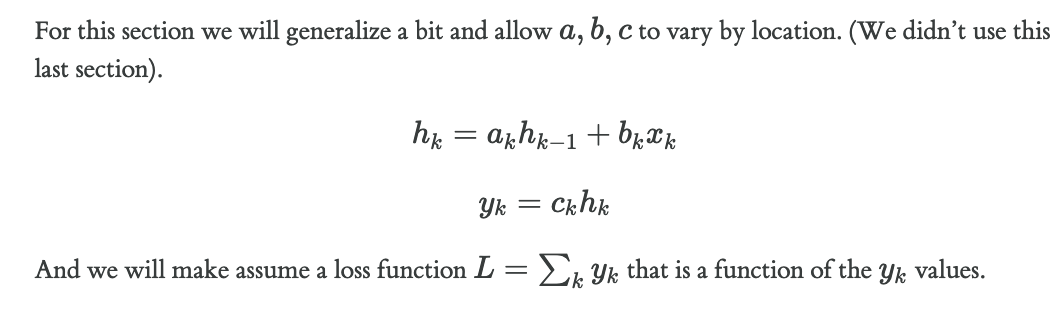

<BarContainer object of 128 artists>

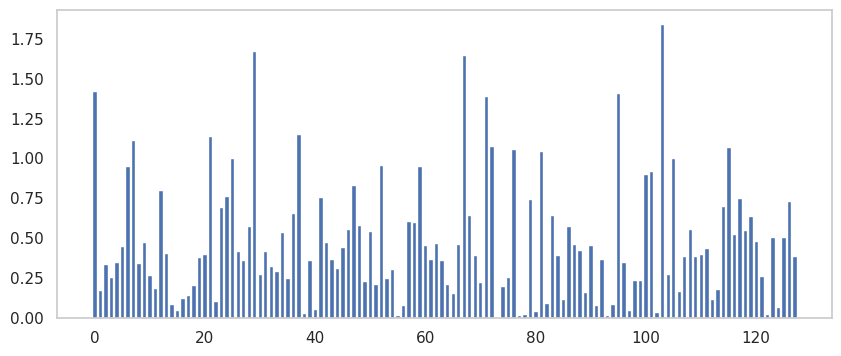

In [23]:
a, b, c = rand((SEQLEN, )), rand((SEQLEN, )), rand((SEQLEN, ))
def ssm_torch(x, a, b, c):
    y = []
    h = 0
    for k in range(len(x)):
        h = a[k] * h + b[k] * x[k]
        y.append(c[k] * h)
    return h, torch.stack(y)

def L(x, a, b, c):
    return ssm_torch(x, a, b, c)[1].sum()

x_ = x.clone()
h, y_ = ssm_torch(x, a, b, c)

g = torch.func.grad(L, tuple(range(4)))
dx_, da_, db_, dc_ = g(x_, a, b, c)

plt.bar(range(SEQLEN), dx_.cpu())

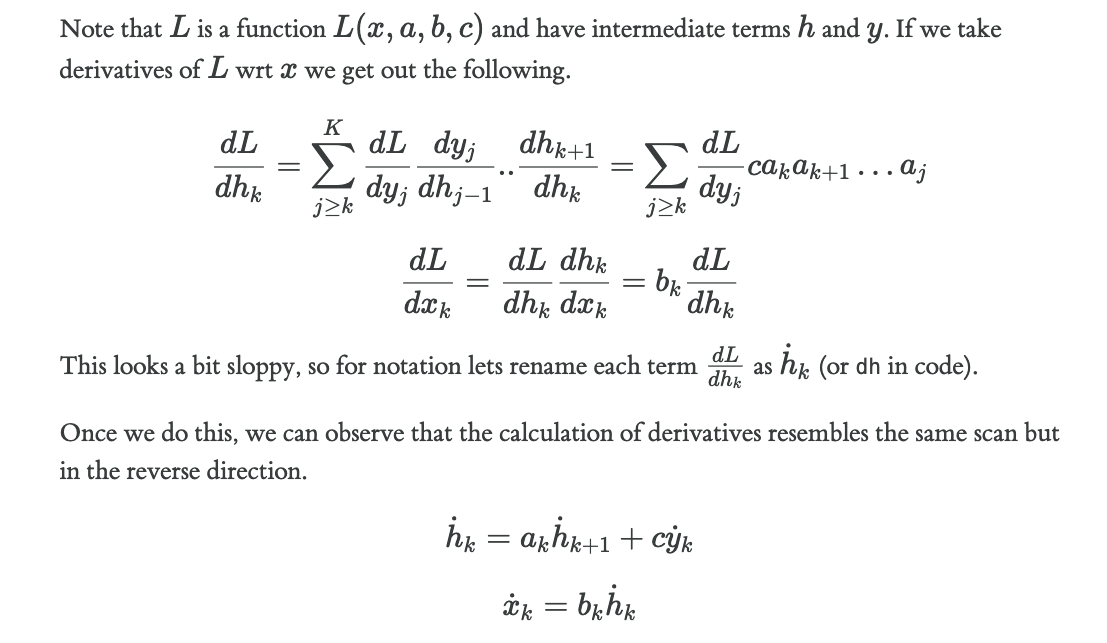

In [24]:
dy, dx = ones(SEQLEN), ones(SEQLEN)
da, db, dc = [torch.zeros(K * BLOCKS).float().cuda() for _ in range(3)]
_, _ign = torch.zeros(K * BLOCKS).cuda(), torch.zeros(K * BLOCKS).cuda()

✔️


<BarContainer object of 128 artists>

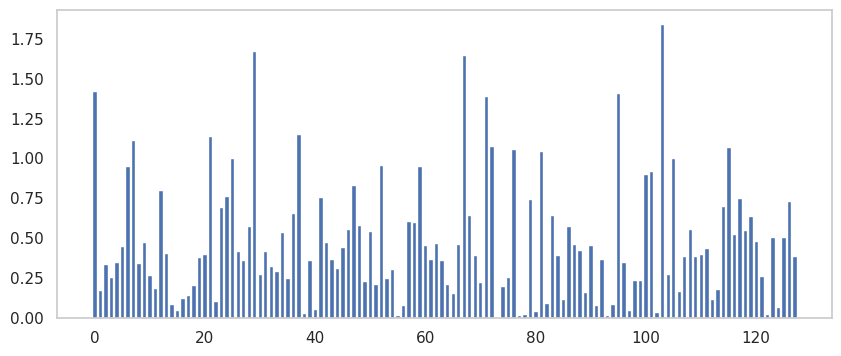

In [25]:
simple_ssm_tt[(1,)](dy.flip(0), a.flip(0).roll(1), c.flip(0), b.flip(0), dx, K = SEQLEN)
dx = dx.flip(0)
check(dx, dx_)
plt.bar(range(SEQLEN), dx.cpu())

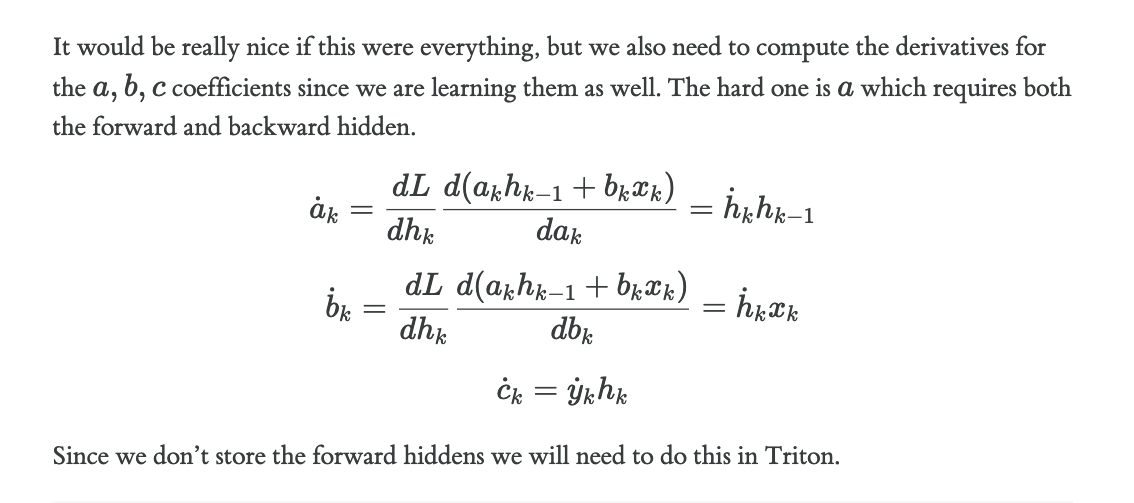

### Triton implementation of the backprop

We do this in Triton because we use the trick from the paper where the matrices are moved to the SRAM and the discretization and scan is done there instead of doing it on the HBM. To save on memory overhead for data transfer between SRAM and HBM, we don't save the forward pass, and thus have to recompute them.

<BarContainer object of 128 artists>

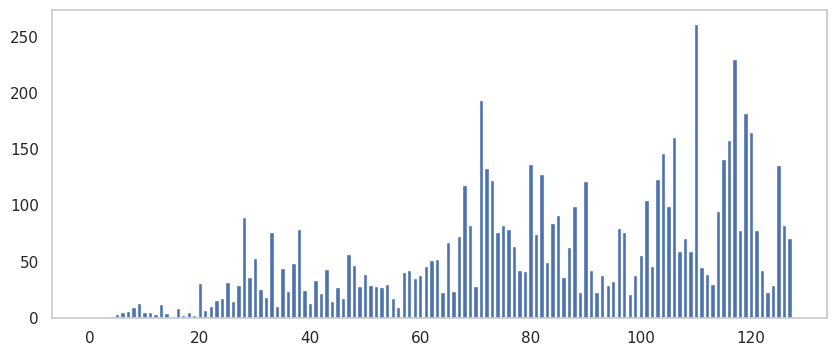

In [26]:
plt.bar(range(SEQLEN), da_.cpu())

In [27]:
@triton.jit
def rol(a1, b1_last, b1_cur, a2, b2_last, b2_cur):
    return a1 + a2, tl.where(a2 == 1, b1_cur, 0) + b2_last, b2_cur

@triton.jit
def roll(y, dim, rev = 0):
    _, rh2, _ = tl.associative_scan((1 + 0 * y, 0.0 * y, y), dim, rol, reverse = rev)
    return rh2

@triton.jit
def ssm_store(Ks, dA, da, dB, db, dC, dc):
    tl.store(dA + Ks, da)
    tl.store(dB + Ks, db)
    tl.store(dC + Ks, dc)

@triton.jit
def ssm1_tt(X, dX, A, dA, B, dB, C, dC, Y, dY, K: tl.constexpr):
    Ks = tl.arange(0, K)
    a,b,c = ssm_load(Ks, A, B, C)
    x = tl.load(X + Ks)
    dy = tl.load(dY + Ks)
    id2 = tl.zeros_like(a) # 0.0

    #compute the forward pass (same as before)
    h1, h2 = ssm_scan(a, b * x, id2)
    y = c * h2
    tl.store( Y + Ks, y)
    a_shift = tl.load(A + Ks + 1, Ks + 1 < K, 0)

    #compute backward(now reversed)
    h1, dh = ssm_scan(a_shift, c * dy, id2, reversed = 1)
    rh2 = roll(h2, 0)

    #save
    tl.store(dX + Ks, b * dh)
    ssm_store(Ks, dA, dh * rh2, dB, dh * x, dC, h2 * dy)

✔️


<BarContainer object of 128 artists>

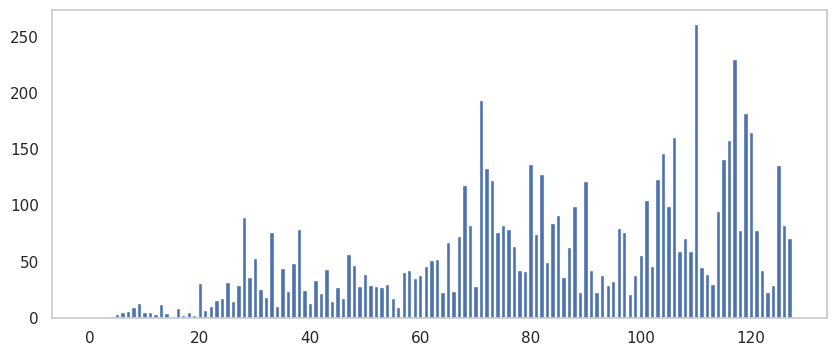

In [28]:
dx, da, db, dc = [torch.zeros(SEQLEN).float().cuda() for _ in range(4)]
dy = torch.ones(SEQLEN).float().cuda()

ssm1_tt[(1,)](x, dx, a, da, b, db, c, dc, y, dy, K = SEQLEN)
check(da, da_, dc, dc_, dx, dx_, db, db_)
plt.bar(range(SEQLEN), da.cpu())

### Block implementation

In [32]:
# Group together all the inputs and all the grads.
@triton.jit
def ssm_tt(X, dX, A, dA, B, dB, C, dC, H_0, dH_0, H, dH, Y, dY,
           back: tl.constexpr,
           K: tl.constexpr):
    pid = tl.program_id(0)
    nH = tl.num_programs(0)

    Ks = tl.arange(0, K)
    kid = pid * K

    # Load
    x = tl.load(X + Ks + kid)
    a, b, c = ssm_load(Ks + kid, A, B, C)
    h2_0 = tl.load(H_0 + nH + Ks*0 + pid, Ks==0, 0)

    # # Compute Forward (Move L-to-R)
    h1, h2 = ssm_scan(a, b * x, h2_0)
    y = c * h2

    tl.store(Y + Ks + kid, y)
    tl.store(H + 0*nH + Ks * 0 + pid, h1, Ks == K-1)
    tl.store(H + 1*nH + Ks * 0 + pid, h2, Ks == K-1)
    if not back: return

    # Compute Backward (Move R-to-L)
    dy = tl.load(dY + Ks + kid)
    a_shift = tl.load(A + Ks + kid + 1)

    dh_0 = tl.load(dH_0 + nH + pid) * (Ks==K-1)
    dh1, dh = ssm_scan(a_shift, c * dy, dh_0, reversed=1)
    rh2 = roll(h2, 0) + h2_0


    # Save
    tl.store(dX + Ks + kid, b * dh)
    ssm_store(Ks + kid, dA, dh*rh2, dB, dh*x, dC, h2 * dy)
    tl.store(dH + 0*nH + Ks * 0 + pid, dh1, Ks == 0)
    tl.store(dH + 1*nH + Ks * 0 + pid, dh,  Ks == 0)

In [35]:
h, dh = (zeros(2, 2, BLOCKS) for _ in range(2))
dx = zeros(SEQLEN)

def run(h, dh):
    ssm_tt[(BLOCKS,)](x, dx, a, da, b, db, c, dc, h, dh, h, dh, y, dy,
                      back=1, K=K)

def reduce(v, rev, batch = 1):
    if rev:
        v[0, :] = v[0].flip(-1)
    o = torch.ones_like(v[0, 0])
    simple_ssm_tt[(batch,)](v[0, 1], v[0, 0], o, o, v[1, 1], K=v.shape[-1])
    v[..., -1] = 0.0
    v[:] = torch.roll(v, 1)
    if rev:
        v[1, :] = v[1].flip(-1)

run(h[0], dh[0])
reduce(h, False)
reduce(dh, True)
run(h[1], dh[1])

dx_, da_, b_, dc_ = g(x, a, b, c)

<BarContainer object of 128 artists>

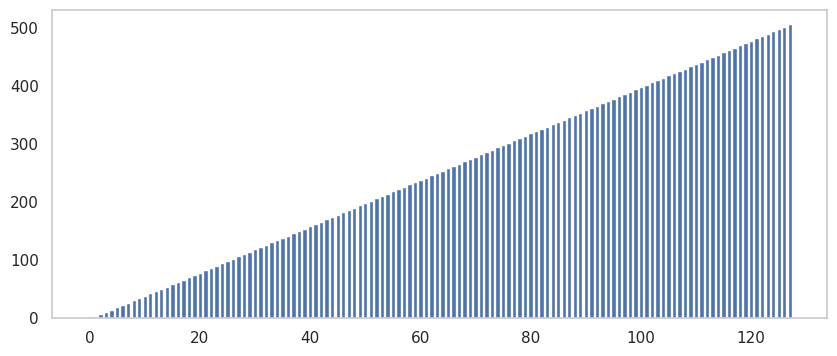

In [36]:
N = 4
def ssm_multiscan(x, a, b, c):
    y = []
    h = zeros(N)
    for k in range(len(x)):
        h = h * a[:, k] + b[:, k] * x[k]
        y.append((c[:, k] * h).sum(0))
    return h, torch.stack(y)

alpha = (((arange(N) + 1) / 8)[:, None]).expand((N, SEQLEN)).clone()
a, b, c = alpha, (1-alpha), ones(N, SEQLEN)
h_, y_ = ssm_multiscan(x, a, b, c)
plt.bar(range(SEQLEN), y_.cpu())


In [37]:
@triton.jit
def select(X, mask, dim=-1):
    return tl.sum(X * mask, dim, 1)

@triton.jit
def multiema_tt(X, A, B, C, H_0, Y, H, K: tl.constexpr,
                L: tl.constexpr, N: tl.constexpr):
    # L is the total length of the sequence.
    pid = tl.program_id(0)
    nH = tl.num_programs(0) # Number of blocks.
    Ks = tl.arange(0, K)[None, :]
    Ns = tl.arange(0, N)[:, None] # N x 1 - For each hidden.
    kid = pid * K
    h_span = Ns*nH + pid

    a, b, c = ssm_load(Ns * L + Ks + kid, A, B, C) # N x K
    x = tl.load(X + Ks + kid) # K
    h2_0 = tl.load(H_0 + nH*N + h_span) * (Ks==0)

    # Compute forward for all hidden.
    h1, h2 = ssm_scan(a, b * x, h2_0, dim=1)
    y = tl.sum(c * h2, 0)

    # Save
    tl.store(Y + Ks + kid, y[None, :])
    tl.store(H + 0 * nH*N + h_span, select(h1, Ks == (K-1)))
    tl.store(H + 1 * nH*N + h_span, select(h2, Ks == (K-1)))

In [38]:
N = 4
h = zeros(2, 2, N, BLOCKS)
o = ones(N, BLOCKS)
multiema_tt[(BLOCKS,)](x, a, b, c, h[0], y, h[0], K=K, L=x.shape[0], N=N)
simple_ssm_tt[(N,)](h[0, 1], h[0, 0], o, o, h[1, 1], K=BLOCKS)
h[..., -1] = 0
multiema_tt[(BLOCKS,)](x, a, b, c, torch.roll(h[1], 1, -1), y, h[1], K=K, L=x.shape[0], N=N)
check(y, y_)

✔️


## Mamba

Text(0.5, 0.5, '$\\Delta$')

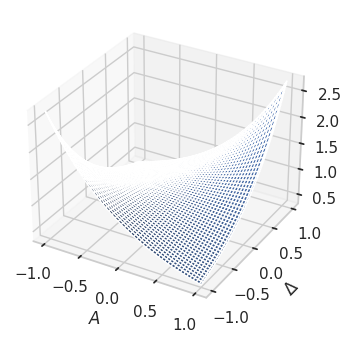

In [39]:
def discretize(a, b, delta):
    da = delta * a
    a_ = torch.exp(da)
    b_ = b * delta
    return a_, b_
ax = plt.figure().add_subplot(projection='3d')
a = torch.linspace(-1, 1, 100)[None].expand(100, 100)
delta = torch.linspace(-1, 1, 100)[:, None].expand(100, 100)
ax.plot_surface(a.cpu(), delta.cpu(), discretize(a, 1, delta)[0].cpu())
ax.set_xlabel('$A$')
ax.set_ylabel('$\Delta$')

In [40]:
x = arange(SEQLEN)
a, b, c, delta = [ones(SEQLEN) for _ in range(4)]
delta[:] = 0.01
def simple_mamba_torch(x, a, b, c, delta):
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(len(x)):
        h = a_[k] * h + b_[k] * x[k]
        y.append(c[k] * h)
    return h, torch.stack(y)

def L(x, a, b, c, delta):
    return simple_mamba_torch(x, a, b, c, delta)[1].sum()

h, y_ = simple_mamba_torch(x, a, b, c, delta)
g = torch.func.grad(L, tuple(range(5)))
dx_, da_, db_, dc_, ddelta_ = g(x_, a, b, c, delta)

In [41]:
delt = 0.5
alpha = 0.9
discretize(torch.tensor(alpha).log() / delt, -torch.tensor(alpha).log(), torch.tensor(delt))

(tensor(0.9000), tensor(0.0527))

In [42]:
@triton.jit
def discretize_tt(a, b, delta):
    da = delta * a
    a_ = tl.exp(da)
    b_ = b * delta
    return a_, b_

@triton.jit
def discretize_back(a, b, d, da_, db_):
    da = d * a
    a_ = tl.exp(da)

    da_da = d * a_
    da_ddelta = a * a_

    inter = (b * (da - 1) * a_ + b) / da

    #db_da = 0
    db_db = d
    db_ddelta = b

    return da_ * da_da, db_ * db_db, da_ * da_ddelta + db_ * db_ddelta

In [43]:
@triton.jit
def mamba1_tt(X, dX, A, dA, B, dB, C, dC, Delta, dDelta, Y, dY, K: tl.constexpr):
    Ks = tl.arange(0, K)
    a, b, c = ssm_load(Ks, A, B, C)
    x = tl.load(X + Ks)
    dy = tl.load(dY + Ks)
    delta = tl.load(Delta + Ks)
    id2 = Ks * 0.0

    # Compute Forward
    a_, b_ = discretize_tt(a, b, delta)
    h1, h2 = ssm_scan(a_, b_ * x, id2)
    y = c * h2
    tl.store(Y + Ks, y)

    # Compute Backward
    h1, dh = ssm_scan(roll(a_, 0, 1), c * dy, id2, reversed=1)
    rh2 = roll(h2, 0)
    da_ = dh*rh2
    db_ = dh*x
    da, db, ddelta = discretize_back(a, b, delta, da_, db_)

    # Save
    tl.store(dDelta + Ks, ddelta)
    tl.store(dX + Ks, b_ * dh)
    ssm_store(Ks, dA, da, dB, db, dC, h2 * dy)

dx, da, db, dc, ddelta = [zeros(SEQLEN) for _ in range(5)]
y, dy = [ones(SEQLEN) for _ in range(2)]
mamba1_tt[(1,)](x, dx, a, da, b, db, c, dc, delta, ddelta, y, dy, K=SEQLEN)
dx_, da_, db_, dc_, ddelta_ = g(x_, a, b, c, delta)
check(y, y_, dx, dx_, da[-2*K:], da_[-2*K:], db[-2*K:], db_[-2*K:], ddelta[-2*K:], ddelta_[-2*K:])

✔️


<BarContainer object of 128 artists>

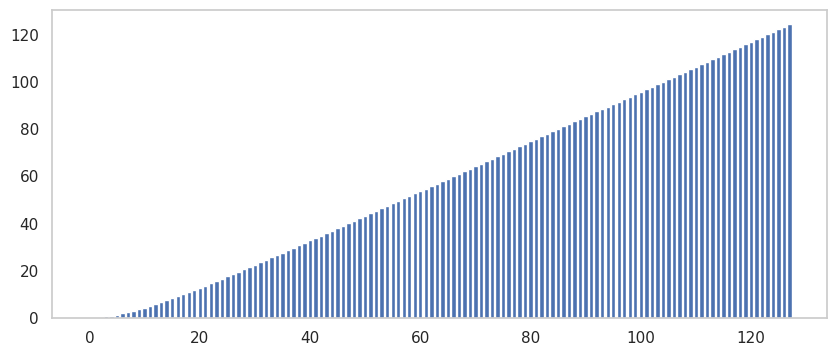

In [44]:
a = (torch.zeros_like(a) + 0.9).log()
b = -(torch.zeros_like(b) + 0.9).log()
delta = torch.ones_like(delta)
mamba1_tt[(1,)](x, dx, a, da, b, db, c, dc, delta, ddelta, y, dy, K=SEQLEN)
plt.bar(range(SEQLEN), y.cpu())

In [45]:
def mamba_torch(x, a, b, c, delta):
    "PyTorch Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdim=True))
    return h, torch.stack(y, -1)

In [46]:
@triton.jit
def mamba_tt(X, dX, A, dA, B, dB, C, dC, Delta, dDelta,
             H_0, dH_0, Y, dY, H, dH,
             back:tl.constexpr,
             step:tl.constexpr,
             L: tl.constexpr, K: tl.constexpr, D_step: tl.constexpr,
             D:tl.constexpr, N: tl.constexpr):
    # Setup
    pid = tl.program_id(0)
    bid = tl.program_id(1)
    kid = pid * K
    nH = tl.num_programs(0)
    Ba = tl.num_programs(1)
    Ks = tl.arange(0, K)[None, None, :] # 1 x 1 x K
    Ns = tl.arange(0, N)[:, None, None] # N x 1 x 1
    Nx1xK = bid*N*L + Ns*L + (Ks + kid)



    # Load forward
    b = tl.load(B + Nx1xK)
    c = tl.load(C + Nx1xK)
    db_out = tl.zeros_like(b)
    dc_out = tl.zeros_like(c)

    Ds = tl.arange(0, D_step)[None, :, None] # 1 x D x 1

    for did in range(0, D // D_step):
        DxK = bid*D*L + Ds*L + Ks + kid
        NxDx1 = bid*N*D + Ns*D + Ds
        a = tl.load(A + NxDx1)
        NxDx1_H = bid*N*D*nH + Ns*D*nH + Ds*nH + pid
        h_off = Ba*N*D*nH

        # Load forward
        delta = tl.load(Delta + DxK)
        x = tl.load(X + DxK)
        a_, b_ = discretize_tt(a, b, delta)

        if step == 2:
            h2_0 = tl.load(H_0 + 1*h_off + NxDx1_H) * (Ks == 0)
        else:
            h2_0 = tl.zeros_like(a_)
        # Compute Forward
        h1, h2 = ssm_scan(a_, b_ * x, h2_0, dim=2)
        y = tl.sum(c * h2, 0, 1)
        if step == 1:
            tl.store(H + 0 * h_off + NxDx1_H + 0*Ks, h1, Ks==K-1)
            tl.store(H + 1 * h_off + NxDx1_H + 0*Ks, h2, Ks==K-1)
        if step == 2:
            tl.store(Y + DxK, y)

        # #Compute backward
        if back == 1:
            # Load Backward
            dy = tl.load(dY + DxK)
            dh2_0 = tl.load(dH_0 + 1*h_off + NxDx1_H) * (Ks==K-1)
            delta_shift = tl.load(Delta + DxK + 1, (Ks + kid) < L - 1, 0)
            a_s, _ = discretize_tt(a, b, delta_shift)
            dh1, dh = ssm_scan(a_s, c * dy, dh2_0, reversed=1, dim=2)
            if step == 1:
                tl.store(dH + 0*h_off + NxDx1_H + 0*Ks, dh1, Ks == 0)
                tl.store(dH + 1*h_off + NxDx1_H + 0*Ks, dh, Ks == 0)

        if back == 1 and step == 2:
            dc = tl.sum(h2 * dy, 1, 1) # N x K
            rh2 = roll(h2, 2)
            rh2 = h2_0 * (Ks == 0) + rh2 * (Ks > 0)
            da, db, ddelta = discretize_back(a, b, delta, dh * rh2, dh * x)

            # Save (sums keep_dims=1)
            tl.store(dX + DxK, tl.sum(b_ * dh, 0, 1))
            tl.store(dA + NxDx1_H, tl.sum(da, 2, 1))
            tl.store(dDelta + DxK, tl.sum(ddelta, 0, 1))
            db_out = db_out + tl.sum(db, 1, 1)
            dc_out = dc_out + dc
        Ds = Ds + D_step

    if back==1 and step==2:
        tl.store(dB + Nx1xK, db_out)
        tl.store(dC + Nx1xK, dc_out)

In [47]:
def create(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [48]:
def mamba(x, a, b, c, delta, K=16, D_step=2):
    Ba = x.shape[0]
    N = a.shape[1]
    D = delta.shape[2]
    SEQLEN = x.shape[-1]
    BLOCKS = SEQLEN // K
    dx, da, db, dc, ddelta = [torch.zeros_like(b) for b in [x,a,b,c,delta]]
    da = zeros(Ba, N, D, BLOCKS)
    y, dy = [ones(Ba, 1, D, SEQLEN) for _ in range(2)]
    h, dh = [zeros(2, 2, Ba, N, D, BLOCKS) for _ in range(2)]
    assert BLOCKS == SEQLEN // K
    assert D % D_step == 0
    mamba_tt[(BLOCKS, Ba)](x, dx, a, da, b, db, c, dc, delta, ddelta, h[0], dh[0], y, dy, h[0], dh[0], back=1, step=1, L=SEQLEN, K=K, D_step=D_step, D=D, N=N)
    reduce(h, False, Ba * N * D)
    reduce(dh, True, Ba * N * D)
    mamba_tt[(BLOCKS, Ba)](x, dx, a, da, b, db, c, dc, delta, ddelta, h[1], dh[1], y, dy, h[1], dh[1], back=1, step=2, L=SEQLEN, K=K, D_step=D_step, D=D, N=N)
    return y, dx, da.sum(-1, keepdim=True), db, dc, ddelta

x, a, b, c, delta = create()
y, dx, da, db, dc, ddelta = mamba(x, a, b, c, delta)
for v in [x, a, b, c, delta]:
    v.requires_grad_()
_, y_ = mamba_torch(x, a, b, c, delta)
y_.sum().backward()
check(y, y_, da, a.grad, dx, x.grad, dc, c.grad, db, b.grad, prec=1e-3)

✔️


In [49]:
import selective_scan_cuda
y_from_repo = selective_scan_cuda.fwd(x.squeeze(1), delta.squeeze(1), a[0].squeeze(-1).T, b.squeeze(-2)[:, None, :, :], c.squeeze(-2)[:, None, :, :], None, None, None, False)

check(y.squeeze(1), y_from_repo[0])

✔️


In [50]:
y_ = mamba(*create(S = 2048, Ba = 8, D = 1024, N=4), K = 128, D_step=16)